## Setup

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, Markdown

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

import scipy.cluster.hierarchy as hac

%matplotlib inline
%config IPCompleter.greedy=True
warnings.filterwarnings('ignore')

Files path `../input/<file>`

In [59]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import pandas as pd
path = "/content/drive/MyDrive/Thesis Data/aps_failure_training_set_processed_8bit.csv"
path_2 = "/content/drive/MyDrive/Thesis Data/aps_failure_test_set_processed_8bit.csv"

train_features = pd.read_csv(path, na_values= 'na')
test_features = pd.read_csv(path_2, na_values = 'na')
data = train_features

train_labels = train_features['class']
test_labels = test_features['class']
train_features = train_features.drop('class', axis=1)
test_features = test_features.drop('class', axis=1)

In [61]:
# !pip install skimpy

In [62]:
# !pip install dtale
# import dtale
# d = dtale.show(data)
# d.open_browser()

In [63]:
# d.open_browser()

In [64]:
# import dtale.app as dtale_app
# dtale_app.USE_COLAB = True
# dtale.show(data)

In [65]:
# from skimpy import skim
# skim(train_features)

In [66]:
# !pip install sweetviz

# import pandas as pd
# import sweetviz as sv

# #EDA using Autoviz
# sweet_report = sv.analyze(train_features)

# #Saving results to HTML file
# sweet_report.show_html('sweet_report.html')
# sweet_report.show_notebook()
# sweet_report.show_notebook(w=1500, h=300, scale=0.8)
# sweet_report.show_html(scale=0.9)

import os
os.listdir('../input')

### Setup hyperparameters

In [152]:
# Set normalization
enable_normalization = True
normalization_type = 'minmax' # 'minmax' or 'standard'

# Exploratory analysis

# Set correlation
enable_correlation = False
enable_dendrogram = False
enable_heatmap = False

# Features Selection

# Set features selection with correlation criteria
enable_correlation_selec = False
factor = 0.95 # number close to 1

# Set features selection with univariate statitics test criteria
enable_univariate_selec = True 
method_selec = 'pca' # 'selectkbest', 'pca', ...
pca_variance = 0.95 
criteria_k_best = chi2 # chi2, mutual_info_classif
k_best = 84 # number of best features to select on select k best.

# Balancing

# Train balancing
enable_balancing = True
number_samples = 2500

# Machine learning method

ml_method = 'mlp'#'randomforestreg' #'mlp'# # 'gradientboosting', 'svm', ...
gbc_loss = 'deviance' # gradient boosting loss
rfc_criterion = 'gini' # random forest criterion
enable_cv = True # enable cross-validation


### Util functions

In [153]:
# Print the bar graph from data
def bar(acumm_data):
    # Do plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax = sns.barplot(x=acumm_data.index, y=acumm_data.values, palette='tab20b', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)    
    return ax

def dendrogram(df):    
    # Do correlation matrix
    corr_matrix = df.corr()

    # Do the clustering
    Z = hac.linkage(corr_matrix, 'single')

    # Plot dendogram
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    groups = hac.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8., # font size for the x axis labels
        color_threshold = 0#,
        #truncate_mode='lastp',
        #p=30
    )

    labels_dict = pd.DataFrame(df.columns).to_dict()[0]
    actual_labels = [item.get_text() for item in ax.get_xticklabels()]
    new_labels = [labels_dict[int(i)] for i in actual_labels]
    ax.set_xticklabels(new_labels)
    plt.tight_layout()

def corr_drop(corr_m, factor=.9):
    
    global cm
    cm = corr_m
    # Get correlation score, as high as this score, more chances to be dropped.
    cum_corr = cm.applymap(abs).sum()
    def remove_corr():
        global cm
        for col in cm.columns:
            for ind in cm.index:
                if (ind in cm.columns) and (col in cm.index):
                    # Compare if are high correlated.
                    if (cm.loc[ind,col] > factor) and (ind!=col):
                        cum = cum_corr[[ind,col]].sort_values(ascending=False)
                        cm.drop(cum.index[0], axis=0, inplace=True)
                        cm.drop(cum.index[0], axis=1, inplace=True)
                        # Do recursion until the last high correlated.
                        remove_corr()
        return cm
    return remove_corr()

## Read data and sepair features from labels

In [154]:
path = "/content/drive/MyDrive/Thesis Data/aps_failure_training_set_processed_8bit.csv"
path_2 = "/content/drive/MyDrive/Thesis Data/aps_failure_test_set_processed_8bit.csv"
train_features = pd.read_csv(path, na_values= 'na')
test_features = pd.read_csv(path_2, na_values = 'na')
data = train_features
train_labels = train_features['class']
test_labels = test_features['class']
train_features = train_features.drop('class', axis=1)
test_features = test_features.drop('class', axis=1)

In [155]:
# # null chack
# col = train_features.iloc[:,1:].columns
# null_ratio = train_features.iloc[:,1:].isnull().sum().values / train_features.shape[0]*100

# # Check by visualization
# plt.figure(figsize=(20,8))
# plt.plot(col, null_ratio)
# plt.xlabel("variables")
# plt.ylabel("ratio(%)")
# plt.xticks(rotation=90, fontsize=10)
# plt.title("Null ratio")
# plt.legend()

## Raw exploratory analysis

In [156]:
train_features.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,-0.124611,-0.071121,-0.198529,-0.007737,-0.033483,-0.040633,-0.006584,-0.026241,-0.040699,-0.074768,...,-0.104808,-0.098734,-0.094976,-0.089227,-0.103374,-0.088961,-0.084540,-0.067471,-0.020035,-0.018417
std,0.367680,0.356812,0.564872,0.004138,0.107086,0.111752,0.032016,0.065200,0.105864,0.186822,...,0.356547,0.362066,0.363148,0.336121,0.320314,0.237613,0.363893,0.261009,0.051907,0.061751
min,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.382812,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
25%,-0.398438,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.375000,-0.343750,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
50%,-0.195312,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.179688,-0.179688,-0.195312,-0.179688,-0.226562,-0.171875,-0.296875,-0.171875,-0.023438,-0.023438
75%,-0.070312,0.000000,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.007812,0.015625,0.015625,0.007812,-0.054688,-0.101562,0.000000,-0.132812,-0.023438,-0.023438
max,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,...,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188


In [157]:
print("No. of columns not containing null values")
print(len(train_features.columns[train_features.notna().all()]))
print("-"*10)

print("Total no. of columns in the dataframe")
print(len(train_features.columns))
print("-"*10)

data.describe(include = 'all')

No. of columns not containing null values
170
----------
Total no. of columns in the dataframe
170
----------


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,-0.959115,-0.124611,-0.071121,-0.198529,-0.007737,-0.033483,-0.040633,-0.006584,-0.026241,-0.040699,...,-0.104808,-0.098734,-0.094976,-0.089227,-0.103374,-0.088961,-0.084540,-0.067471,-0.020035,-0.018417
std,0.254040,0.367680,0.356812,0.564872,0.004138,0.107086,0.111752,0.032016,0.065200,0.105864,...,0.356547,0.362066,0.363148,0.336121,0.320314,0.237613,0.363893,0.261009,0.051907,0.061751
min,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.382812,-0.382812,-0.382812,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
25%,-0.992188,-0.398438,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.343750,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
50%,-0.992188,-0.195312,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.179688,-0.179688,-0.195312,-0.179688,-0.226562,-0.171875,-0.296875,-0.171875,-0.023438,-0.023438
75%,-0.992188,-0.070312,0.000000,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,...,-0.007812,0.015625,0.015625,0.007812,-0.054688,-0.101562,0.000000,-0.132812,-0.023438,-0.023438
max,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,...,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188


In [158]:
# columns_list = train_features.columns

# from collections import Counter
# import matplotlib.pyplot as plt
# def get_tag(name):
#     return name.split("_")[0]

# all_columns_with_tags = [a for a in columns_list if "_" in a]
# all_tags = [get_tag(a) for a in all_columns_with_tags]
# hists = [k for k,v in Counter(all_tags).items() if v == 10]
# hists_columns = [k for k in all_columns_with_tags if get_tag(k) in hists]
# hists_dict = {k:[col for col in hists_columns if k in col] for k in hists if get_tag(k) in hists}
# counter_columns = [k for k in all_columns_with_tags if get_tag(k) not in hists]

In [159]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 12}
# plt.rc('font', **font)
# df_dist = {}
# for dist in hists:
#     pds_to_concat = []
#     for i,col in enumerate(hists_dict[dist]):
#         temp = data[[col,'Class']]
#         temp["ref"] = col
#         temp.loc[temp[col]>=0,col] = np.log(temp[col]+1)
#         temp.columns = ["data","Class","ref"]
#         pds_to_concat.append(temp)
#     df_dist[dist] = pd.concat(pds_to_concat)
#     df_dist[dist] = df_dist[dist][df_dist[dist].data>=0] # No NA values
# #ag_dist.data = np.log(ag_dist.data+1)
# fig , axs = plt.subplots(7)
# fig.set_figheight(15)
# fig.set_figwidth(15)
# #sns.boxenplot(data=ag_dist,x="ref",y="data",hue="class",outlier_prop=0.00000000001)
# for i,hist in enumerate(hists):
#     sns.violinplot(data=df_dist[hist],x="ref",y="data",hue="Class",scale="width",scale_hue=True
#                    , split=True,ax=axs[i],legend=(i==0));
# fig.text(0.04, 0.5, 'Distribution of each feature per outcome', va='center', rotation='vertical');

In [160]:
# corr = df_num.drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
# plt.figure(figsize=(12, 10))

# sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
#             cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
#             annot=True, annot_kws={"size": 8}, square=True);

In [161]:
# # Discrete Variable Correlation by Failure using
# # group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
# for x in data1_x:
#     if data1[x].dtype != 'float64' :
#         print('Failure Correlation by:', x)
#         print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
#         print('-'*10, '\n')

## Pre-processing

### Flat dataframe and check for non-valid values

If doesn't exist, it is considered non-valid.

In [162]:
flat_data = train_features.values.flatten()
count=0
for value in flat_data:
    if value is not None:
        continue
    count+= 1
pct_nan = round(100*count/len(flat_data))
print(f'{pct_nan}% of data are non-valid.')

0% of data are non-valid.


### Scalling

Apply MinMaxScaler with values between 0 and 1.

Ref: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [163]:
from sklearn.preprocessing import MinMaxScaler
if enable_normalization and normalization_type=='minmax':
    scaler = MinMaxScaler()
    scaler.fit(train_features)
    train_features = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns)

Exploratory analysis after scalling.

In [164]:
train_features.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.201396,0.170101,0.184964,0.000076,0.012888,0.013425,0.001228,0.004894,0.013362,0.038237,...,0.202185,0.206603,0.209336,0.195227,0.160288,0.089559,0.169752,0.089689,0.003350,0.004943
std,0.262922,0.278488,0.386650,0.004138,0.103060,0.106749,0.032016,0.063707,0.101124,0.168403,...,0.259307,0.263321,0.264107,0.250137,0.245510,0.200095,0.280592,0.224222,0.051108,0.060801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005682,0.005814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.150838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.147727,0.147727,0.136364,0.127907,0.065868,0.019737,0.006024,0.000000,0.000000,0.000000
75%,0.240223,0.225610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.272727,0.289773,0.289773,0.267442,0.197605,0.078947,0.234940,0.033557,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Processing train labels

Round values and replace -1 with 0 making all labels positives.

In [165]:

train_labels = train_labels.apply(round)
train_labels = train_labels.replace({-1:0})

### Show labels porportion

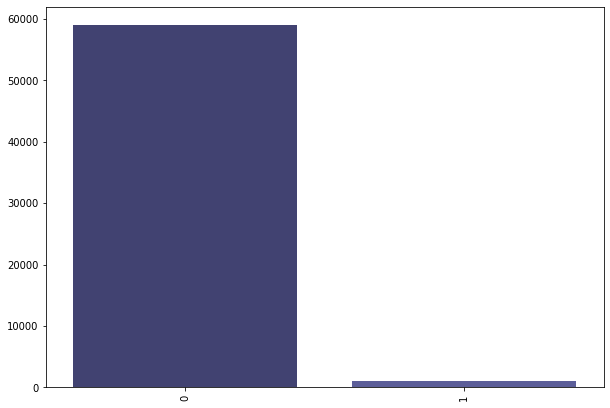

In [166]:
bar(train_labels.value_counts())
plt.show()

## Processing and analysis over data

### Correlation analysis

Used method: Pearson distance. Ref: https://pt.wikipedia.org/wiki/Correla%C3%A7%C3%A3o#Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson

In [167]:
if enable_correlation and enable_dendrogram:
    corr_matrix = train_features.corr()
    dendrogram(corr_matrix)
    plt.tight_layout()

Correlation matrix heatmap.

In [168]:
if enable_correlation and enable_heatmap:
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(corr_matrix, square=True, cmap='Purples', ax=ax)
    plt.tight_layout()
    plt.show()

[](http://)The data has a lot of features, because of that, is very difficulty to visualize hierarchical graphs,
<br> One option is to use a pipeline with selection attribute method to reduce number of features and than dropping the high correlated features.

### Feature selection by univariate statistics test

Ref.: 
<br> http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
<br> https://en.wikipedia.org/wiki/Chi-squared_distribution

In [169]:
# to enable run correlation selection without univariate selection.
best_train_features = train_features 
new_corr_matrix = best_train_features.corr()

In [170]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        selectKBest = SelectKBest(chi2, k  = 84)
        selectKBest.fit(train_features, train_labels)
        best_train_features = selectKBest.transform(train_features)

        idxs_selected = selectKBest.get_support(indices=True)
        best_train_features = train_features.iloc[:,idxs_selected]


Selected columns.

In [171]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        print(best_train_features.columns) # selected columns

Descritive analysis after feature selection

In [172]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        best_train_features.describe()

In [173]:
best_train_features.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.201396,0.170101,0.184964,0.000076,0.012888,0.013425,0.001228,0.004894,0.013362,0.038237,...,0.202185,0.206603,0.209336,0.195227,0.160288,0.089559,0.169752,0.089689,0.003350,0.004943
std,0.262922,0.278488,0.386650,0.004138,0.103060,0.106749,0.032016,0.063707,0.101124,0.168403,...,0.259307,0.263321,0.264107,0.250137,0.245510,0.200095,0.280592,0.224222,0.051108,0.060801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005682,0.005814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.150838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.147727,0.147727,0.136364,0.127907,0.065868,0.019737,0.006024,0.000000,0.000000,0.000000
75%,0.240223,0.225610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.272727,0.289773,0.289773,0.267442,0.197605,0.078947,0.234940,0.033557,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Correlation after feature selection

In [174]:
if enable_univariate_selec:
    if method_selec=='selectkbest':
        new_corr_matrix = best_train_features.corr()
        dendrogram(new_corr_matrix)
        plt.tight_layout()

![](http://)__Obs: __ You can make a pipeline with feature selction method and feature selection by correlation, just enable both in *Setup hyperparameters*

### Only mantain the best feature between the high correlated features

In [175]:
if enable_correlation_selec:
    new_new_corr_matrix = corr_drop(new_corr_matrix, factor)
    print(f'Number of features selected is {len(new_new_corr_matrix.columns)}.')

In [176]:
if enable_correlation_selec:
    dendrogram(new_new_corr_matrix)
    plt.tight_layout()

In [177]:
if enable_correlation_selec:
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(new_new_corr_matrix, square=True, cmap='Purples', ax=ax)
    plt.tight_layout()
    plt.show()

In [178]:
if enable_correlation_selec:
    best_train_features = best_train_features.loc[:,new_new_corr_matrix.columns]

### Feature extraction with PCA

In [179]:
if method_selec=='pca':
    pca = PCA(pca_variance)
    pca.fit(train_features)
    best_train_features = pca.transform(train_features)
    best_train_features = pd.DataFrame(best_train_features)

Text(0.5, 1.0, 'Scale up')

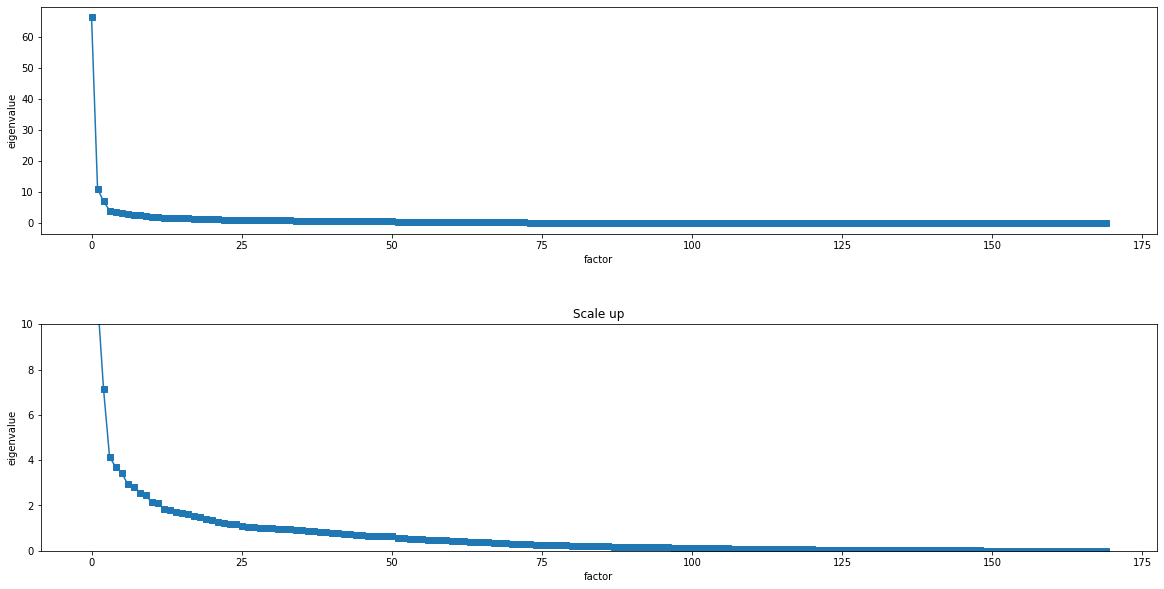

In [180]:
eigen_vals = sorted(np.linalg.eigvals(train_features.corr()), reverse=True)

# plot
fig, ax = plt.subplots(2, 1, figsize=(20,10))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(eigen_vals, 's-')
ax[0].set_xlabel("factor")
ax[0].set_ylabel("eigenvalue")

ax[1].plot(eigen_vals, 's-')
ax[1].set_xlabel("factor")
ax[1].set_ylabel("eigenvalue")
ax[1].set_ylim([0,10])
ax[1].set_title("Scale up")

In [181]:
if method_selec=='pca':
  {pca.n_components_}

In [182]:
if method_selec=='pca':
    print('Number of components {pca.n_components_}')

Number of components {pca.n_components_}


## Modeling

### Balancing

In [183]:
# to enable run without balancing
best_train_features_balanced = best_train_features
train_labels_balanced = train_labels

In [184]:
if enable_balancing:
  from imblearn.under_sampling import RandomUnderSampler
  rus = RandomUnderSampler(random_state=0)

  best_train_features_balanced, train_labels_balanced = rus.fit_resample(best_train_features, train_labels)

In [185]:
train_labels_balanced.value_counts()

0    1000
1    1000
Name: class, dtype: int64

In [186]:
# if enable_balancing:
#     idxs_pos = train_labels[train_labels==1].index
#     idxs_neg = train_labels[train_labels==0].sample(n=number_samples, replace=False, random_state=0).index
#     idxs_balanced = np.concatenate((idxs_pos,idxs_neg))
#     best_train_features_balanced = best_train_features.loc[idxs_balanced]
#     train_labels_balanced = train_labels.loc[idxs_balanced]
#     print(f'Proportion balanced: {int(number_samples/1000)}/1')

In [187]:
if ml_method=='randomforestreg':
    rfc = RandomForestRegressor(n_estimators=100, oob_score = True, random_state=0, n_jobs=3)
    rfc.fit(best_train_features_balanced, train_labels_balanced)
    print(rfc)

In [188]:
if ml_method=='mlp':
    # Seed value
  # Apparently you may use different seed values at each stage
  seed_value= 0

  # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
  import os
  os.environ['PYTHONHASHSEED']=str(seed_value)

  # 2. Set the `python` built-in pseudo-random generator at a fixed value
  import random
  random.seed(seed_value)

  # 3. Set the `numpy` pseudo-random generator at a fixed value
  import numpy as np
  np.random.seed(seed_value)

  # 4. Set the `tensorflow` pseudo-random generator at a fixed value
  import tensorflow as tf
  #tf.random.set_seed(seed_value)
  # for later versions: 
  tf.compat.v1.set_random_seed(seed_value)

  # 5. Configure a new global `tensorflow` session
  from keras import backend as K
  # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  # K.set_session(sess)
  # for later versions:
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  n_features = best_train_features_balanced.shape[1]
  from tensorflow.keras.layers import BatchNormalization
  from keras.layers import Activation, Dense
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Dropout
  from tensorflow.keras.optimizers import SGD
  from tensorflow.keras.callbacks import TensorBoard
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.callbacks import EarlyStopping
  from tensorflow.keras import regularizers
  from datetime import datetime
  model = Sequential()
  model.add(Dense(492, activation='relu', input_shape=(n_features,)))
  model.add(BatchNormalization(axis=-1, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones'))
  model.add(Dropout(0.25)) ###using dropout
  model.add(Dense(328, activation='relu'))
  model.add(BatchNormalization(axis=-1, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones'))
  model.add(Dropout(0.25)) ###using dropout
  model.add(Dense(82, activation='relu'))
  model.add(BatchNormalization(axis=-1, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['Precision'])
  history = model.fit(best_train_features_balanced, train_labels_balanced, epochs=300, batch_size=450, verbose=0)

In [189]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 492)               24108     
                                                                 
 batch_normalization_9 (Batc  (None, 492)              1968      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 492)               0         
                                                                 
 dense_13 (Dense)            (None, 328)               161704    
                                                                 
 batch_normalization_10 (Bat  (None, 328)              1312      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 328)              

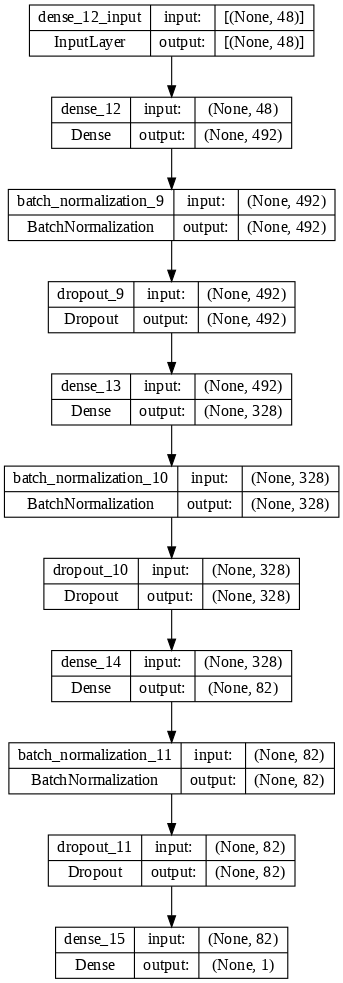

In [190]:
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=80
)

In [107]:
from matplotlib import pyplot as plt

from google. colab import files
plt.savefig("model_plot.png")
files.download("model_plot.png")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

## Prediction

In [108]:
# to enable change feature selection method
best_test_features = test_features  

### Apply scalling over test data

In [ ]:
from sklearn.preprocessing import StandardScaler
if enable_normalization:
    scaler.transform(best_test_features)
    best_test_features = pd.DataFrame(scaler.transform(best_test_features), columns=best_test_features.columns)

### Apply feature selection over test data

In [ ]:
if enable_univariate_selec:
    if method_selec=='selectkbest':        
        X = selectKBest.transform(best_test_features)
        idxs_selected = selectKBest.get_support(indices=True)
        best_test_features = best_test_features.iloc[:,idxs_selected]
    if method_selec=='pca':        
        best_test_features = pca.transform(best_test_features)
if enable_correlation_selec:
    best_test_features = best_test_features.loc[:,new_new_corr_matrix.columns]

### Processing labels

As same as done with train labels.

In [ ]:
test_labels = test_labels.apply(round)
test_labels = test_labels.replace({-1:0})

### Make prediction with trainned model choosen and show report

In [ ]:
if ml_method=='mlp':
  seed_value= 4
  # fit the model
  y_pred = model.predict(best_test_features)
  y_pred = np.round(y_pred)
  report = classification_report(test_labels, y_pred)

500/500 [==============================] - 1s 2ms/step


In [ ]:
if ml_method=='mlp1':
  # fit the model
  y_pred = model.predict(best_test_features)
  y_pred = np.round(y_pred)
  report = classification_report(test_labels, y_pred)

### Show confusion matrix
Ref.
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [ ]:
cm = confusion_matrix(test_labels, y_pred).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
display(cm)

,tn,fp,fn,tp
0,14786,839,11,364


### Show total cost obtained

In [ ]:
total_cost = 10*cm.fp + 500*cm.fn
def printmd(string):
    display(Markdown(string))
printmd(f'Total cost is: \n# <p><span style="color:purple">${float(total_cost.values[0])}</span></p>')


Total cost is: 
# <p><span style="color:purple">$13890.0</span></p>

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.946875
Precision: 0.302577
Recall: 0.970667
F1 score: 0.461343


In [ ]:
print("Ratio of memory usage in bytes (original to reduced): {:.5f}".format(train_features.memory_usage().sum() / best_train_features_balanced.memory_usage().sum()))

Ratio of memory usage in bytes (original to reduced): 60.70860


In [ ]:
#Random undersampling along with feature selection = false
# Accuracy: 0.958750
# Precision: 0.357926
# Recall: 0.957333
# F1 score: 0.521045
# # Ratio of memory usage in bytes (original to reduced): 17.04%
#cost = 14440

#Random undersampling along with feature selection = True (k best_ mutual_info_classif)
# Accuracy: 0.961063
# Precision: 0.372690
# Recall: 0.968000
# F1 score: 0.538176
# Ratio of memory usage in bytes (original to reduced): 34.28577
# cost : 12110

#Random undersampling along with feature selection = True (k best_ chi2)
# Accuracy: 0.961187
# Precision: 0.373457
# Recall: 0.968000
# F1 score: 0.538976
#Ratio of memory usage in bytes (original to reduced): 34.28577
# cost : 12090


#Random undersampling along with feature selection = true(PCA)
# Accuracy: 0.956375
# Precision: 0.345158
# Recall: 0.960000
# F1 score: 0.507757
# Ratio of memory usage in bytes (original to reduced): 59.47531
# Cost : 14330

#Random undersampling with 1: 1 Ratio along with feature selection = false
#Accuracy: 0.943375
#Precision: 0.289118
#Recall: 0.970667
#F1 score: 0.445532
#Ratio of memory usage in bytes (original to reduced): 29.99864
#cost : $14450.0



#Random undersampling with 1: 1 Ratio along with feature selection = true(select k best):mutualinfo
# Accuracy: 0.946875
# Precision: 0.302577
# Recall: 0.970667
# F1 score: 0.461343
#Ratio of memory usage in bytes (original to reduced): 60.70860
# cost : 13890

#Random undersampling with 1: 1 Ratio along with feature selection = true(select k best):chi2
# Accuracy: 0.946937
# Precision: 0.302829
# Recall: 0.970667
# F1 score: 0.461636
# Ratio of memory usage in bytes (original to reduced): 60.70860
# cost : 13880.0


#Random undersampling with 1: 1 Ratio along with feature selection = true(pca)
# Accuracy: 0.941438
# Precision: 0.282844
# Recall: 0.976000
# F1 score: 0.438586
# Ratio of memory usage in bytes (original to reduced): 106.23246
#cost : $13780.0



